# Course 2: Flow and Bridge Matching

# Flow matching

We need to define three functions:
* **The conditional forward proess**, i.e., sample $x_t$ given $x_0, x_1, t$. Since $p_{t | 1}$ or $p_{t | 0, 1}$ are available in closed form, we do not need to simulate a forward SDE; this is the *the simulation-free* property.
* **The objective function**, which is a flow matching squared $L_2$ loss to obtain the corresponding marginal vector field.
* **The sampling algorithm**, i.e., a simulation of the ODE.

Device in use: mps
Using Gaussian Mixture dataset, with parameters mean=[-1.5, 0.0], [1.5, 0.0] and std=0.5. 10000 samples.


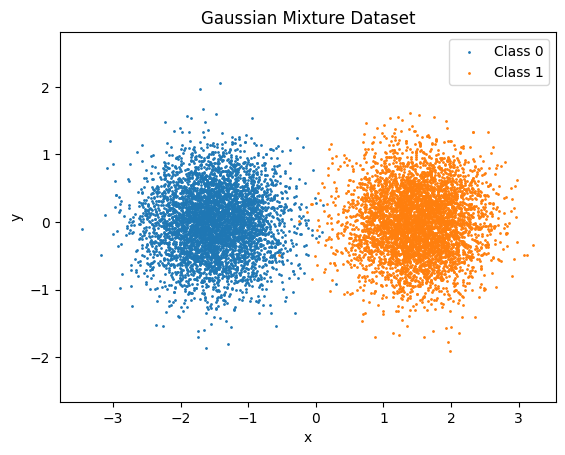

Using Gaussian Mixture dataset, with parameters mean=[-1.5, 0.0], [1.5, 0.0] and std=0.5. 10000 samples.
Using Gaussian Mixture dataset, with parameters mean=[-1.5, 0.0], [1.5, 0.0] and std=0.5. 10000 samples.
dataset shape torch.Size([10000, 2, 2])
labels shape torch.Size([10000, 2])


In [1]:
import torch

def get_device():
    """
    Returns the available device ('cuda', 'mps', or 'cpu').
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
    
device = get_device()
print('Device in use:', device)

# Create a dataset with a Gaussian mixture distribution:
def get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples):
    print('Using Gaussian Mixture dataset, with parameters mean=[{}, {}], [{}, {}] and std={}. {} samples.'
          .format(mean1[0], mean1[1], mean2[0], mean2[1], std, n_samples))
    # Half the samples from each mixture component.
    samples1 = torch.randn(n_samples // 2, 2) * std + mean1
    samples2 = torch.randn(n_samples - n_samples // 2, 2) * std + mean2
    samples = torch.concatenate([samples1, samples2], dim=0)
    labels = torch.zeros(n_samples)
    labels[n_samples // 2:] = 1
    return samples, labels

def get_default_gaussian_mixture_datapoints():
    mean1 = torch.tensor([-1.5, 0])
    mean2 = torch.tensor([1.5, 0])
    std = 0.5
    n_samples = 10000
    gaussian_datapoints, labels = get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples)
    # shuffle the data
    perm = torch.randperm(n_samples)
    gaussian_datapoints = gaussian_datapoints[perm]
    labels = labels[perm]
    return gaussian_datapoints, labels

# random shuffle
gaussian_datapoints, labels = get_default_gaussian_mixture_datapoints()

# plot the Gaussian mixture dataset
import matplotlib.pyplot as plt
plt.scatter(gaussian_datapoints[labels == 0, 0], gaussian_datapoints[labels == 0, 1], s=1, label='Class 0')
plt.scatter(gaussian_datapoints[labels == 1, 0], gaussian_datapoints[labels == 1, 1], s=1, label='Class 1')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Gaussian Mixture Dataset')
plt.show()


# Create a TensorDataset
def create_dataset(datapoints, labels):
    dataset_obj = torch.utils.data.TensorDataset(datapoints, labels)
    return dataset_obj

def create_dataloader(dataset, batch_size):
    # Create a DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False
        )
    return dataloader


gaussian_datapoints_0, labels_0 = get_default_gaussian_mixture_datapoints()
gaussian_datapoints_1, labels_1 = get_default_gaussian_mixture_datapoints()
gaussian_datapoints_0 = gaussian_datapoints_0.unsqueeze_(1)
gaussian_datapoints_1 = gaussian_datapoints_1.unsqueeze_(1)
labels_0 = labels_0.unsqueeze_(1)
labels_1 = labels_1.unsqueeze_(1)
gaussian_datapoints = torch.cat([gaussian_datapoints_0, gaussian_datapoints_1], dim=1)
labels = torch.cat([labels_0, labels_1], dim=1)
print('dataset shape', gaussian_datapoints.shape)
print('labels shape', labels.shape)
dataset_obj = create_dataset(gaussian_datapoints, labels)
dataloader = create_dataloader(dataset_obj, batch_size=500)

In [2]:
from model.SimpleModelConditioned import MLPModel

# define a simple MLP model. For the moment, take the default one I provide

def get_model_and_optimizer(num_classes=0):
    simple_model = MLPModel(
        nfeatures = 2,
        time_emb_size= 8,
        nblocks = 2,
        nunits = 32,
        skip_connection = True,
        layer_norm = True,
        dropout_rate = 0.,
        learn_variance = False,
        num_classes=num_classes
    )

    simple_model = simple_model.to(device)

    # setting up the optimizer
    import torch.optim as optim

    optimizer = optim.AdamW(
        simple_model.parameters(), 
        lr=2e-3, 
        betas=(0.9, 0.999))

    return simple_model, optimizer

## Forward : sample $p_{t | 1}$

We implement the simplest rectiflied flow: 

$$\phi_t(x_0, x_1) = x_t = tx_1 + (1 - t)x_0. $$

Thus, the conditional vector field $v_{t | 1}$ is equal to

$$ v_{t | 1}(x_t | x_1) = x_1 - x_0 = x_1 - \frac{x_t - tx_1}{1 - t} = \frac{x_1 - x_t}{1 - t}. $$ 





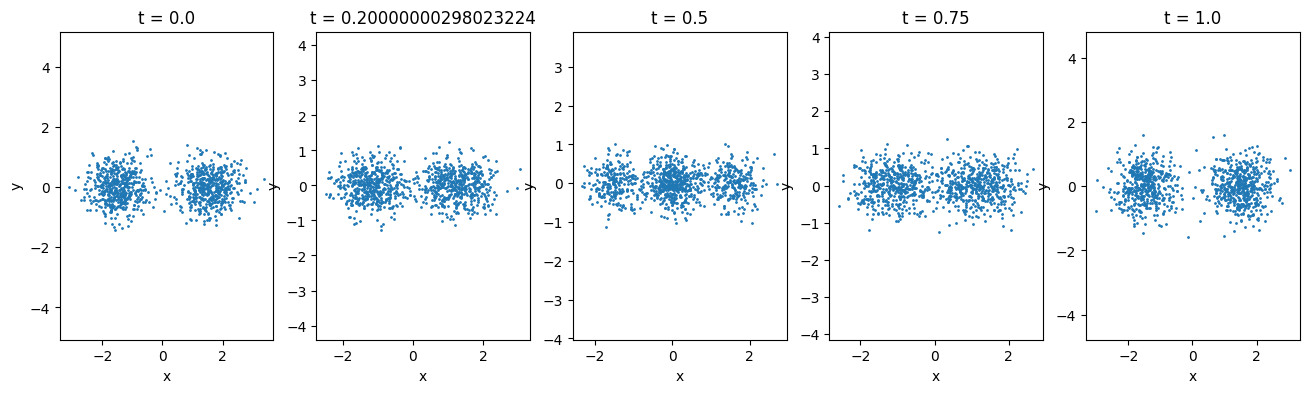

In [3]:
import torch

def simulation_free_forward(x0, x1, t):
    return (1 - t) * x0 + t * x1

def conditional_vector_field(x0, x1, t):
    return x1 - x0


# check the forward process by plotting the empirical marginals p_t, for some t and empirical samples

X, L = dataset_obj[:1000]
x1 = X[:, 1, :]
x0 = X[:, 0, :]

# create four subplots 
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

# plot the empirical marginals p_t
def plot_ax_i(ax, x, y, title):
    ax.scatter(x, y, s=1)
    ax.axis('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)

for i, t_norm in enumerate([0.0, 0.2, 0.5, 0.75, 1.0]):
    t = t_norm * torch.ones_like(x0)
    x_t = simulation_free_forward(x0, x1, t)
    plot_ax_i(axs[i], x_t[:, 0], x_t[:, 1], 't = {}'.format(t[0, 0]))

plt.show()




## Conditional Flow Matching loss

The flow matching loss is given by 

$$ \mathcal{L}_{\text{CFM}}(\theta) = \mathbb{E}\left[ \| v_{\theta}(X_t, t) - (X_1 - X_0) \|^2 \right].$$ 

In [4]:
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment  # for the optimal transport assignment

def training_losses(model, x0, x1, y):
    batch_size = x0.shape[0]
    
    # Sample a random time t for each sample in the batch (values in [0, 1])
    t = torch.rand(batch_size, device=x0.device)
    # expand t tensor to the same shape as x0 and x1
    expanded_t = t.view(-1, 1).expand_as(x0)
    
    
    # Compute the simulation-free forward process: linear interpolation between x0 and x1
    x_t = (1 - expanded_t)* x0 + expanded_t* x1
    
    # Compute the ground truth conditional vector field (which is x1 - x0 for linear interpolation)
    v_target = x1 - x0
    
    # Predict the vector field using the neural network model.
    # We assume the model takes x_t and t as separate inputs.
    v_pred = model(x_t, t, y)
    
    # Compute the mean squared error loss between the predicted and target vector fields.
    loss = F.mse_loss(v_pred, v_target)
    
    return loss

# training loop

import os

def train(
    num_epochs, 
    checkpoint_interval, 
    dataloader,
    model,
    optimizer,
    checkpoint_dir,
    device,
    use_conditioning=False,
    mini_batch_ot=False,
):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()
    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        running_loss = 0.0
        for batch_idx, (data, y) in (enumerate(dataloader)):
            data = data.to(device) 
            optimizer.zero_grad()

            # extract x_0, x_1 with independent coupling
            x1 = data[:, 1, :]
            x0 = data[:, 0, :]
            
            y1 = None
            if use_conditioning:
                y1 = y[:, 1].to(device)
                y0 = y[:, 0]
            
            # If mini_batch_ot is True, we will compute the optimal transport plan between x0 and x1
            # and permute x1 according to the optimal transport plan.
            if mini_batch_ot:
                # Compute the pairwise cost matrix between x0 and x1 using squared Euclidean distance.
                cost_matrix = torch.cdist(x0, x1, p=2) ** 2
                cost_matrix_np = cost_matrix.detach().cpu().numpy()
                # Compute the optimal assignment (Hungarian algorithm)
                row_ind, col_ind = linear_sum_assignment(cost_matrix_np)
                # Permute x1 according to the optimal transport plan
                x1 = x1[col_ind]
                
            
            # Compute the training loss.
            loss = training_losses(model, x0=x0, x1=x1, y=y1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # Save a checkpoint every checkpoint_interval epochs.
        if epoch % checkpoint_interval == 0:
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_losses': epoch_losses,
            }, checkpoint_path)
            print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")


simple_model, optimizer = get_model_and_optimizer(num_classes=2)
# RUN!
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=dataloader,
    model=simple_model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device=device,
    use_conditioning=False,
    mini_batch_ot=False
)

Training on device: mps
Epoch [1] Average Loss: 2.8416
Epoch [2] Average Loss: 2.7254
Epoch [3] Average Loss: 2.6367
Epoch [4] Average Loss: 2.1190
Epoch [5] Average Loss: 1.8822
Epoch [6] Average Loss: 1.8230
Epoch [7] Average Loss: 1.7860
Epoch [8] Average Loss: 1.7985
Epoch [9] Average Loss: 1.7448
Epoch [10] Average Loss: 1.7316
Epoch [11] Average Loss: 1.7255
Epoch [12] Average Loss: 1.7333
Epoch [13] Average Loss: 1.6791
Epoch [14] Average Loss: 1.6667
Epoch [15] Average Loss: 1.6714
Epoch [16] Average Loss: 1.6579
Epoch [17] Average Loss: 1.7068
Epoch [18] Average Loss: 1.7267
Epoch [19] Average Loss: 1.6555
Epoch [20] Average Loss: 1.6799
Epoch [21] Average Loss: 1.6451
Epoch [22] Average Loss: 1.6842
Epoch [23] Average Loss: 1.6503
Epoch [24] Average Loss: 1.6913
Epoch [25] Average Loss: 1.6755
Epoch [26] Average Loss: 1.6857
Epoch [27] Average Loss: 1.6742
Epoch [28] Average Loss: 1.7235
Epoch [29] Average Loss: 1.6800
Epoch [30] Average Loss: 1.6772
Epoch [31] Average Loss: 

In [5]:
# load the model from checkpoint
def load_model_from_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_losses = checkpoint['epoch_losses']
    return model, optimizer, epoch, epoch_losses

# load the model from the last checkpoint
checkpoint_path = 'checkpoints/checkpoint_epoch_50.pth'
simple_model, optimizer, epoch, epoch_losses = load_model_from_checkpoint(checkpoint_path, simple_model, optimizer)

## Generative Process; simulate the ODE

The generative process is simply given by

$$ d X_t = v_{\theta}(X_t, t)dt $$

100%|██████████| 100/100 [00:00<00:00, 234.67it/s]


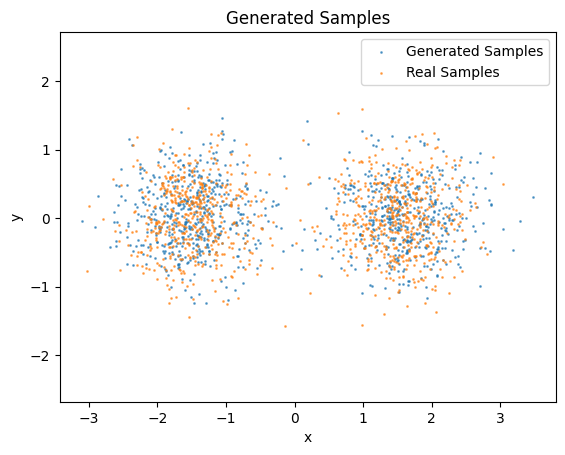

In [6]:
from tqdm import tqdm

def sample(model, n_samples, n_steps, use_conditioning=False):
    
    # initial samples
    x0 = gaussian_datapoints[:n_samples, 0, :].to(device)
    if use_conditioning:
        y = labels[:n_samples, 1].to(device)
    else:
        y  = None
    
    model.eval()
    
    dt = 1.0 / n_steps
    x = x0.clone()  # Ensure we do not modify the original x0

    with torch.inference_mode():
        # Integrate from t=0 to t=1 in n_steps steps
        for i in tqdm(range(n_steps)):
            # Create a time tensor for the current step with shape (batch_size, 1)
            t = torch.full((x.shape[0], 1), i * dt, device=device)
            # Get the predicted vector field from the trained model
            v = model(x, t, y)
            # Update x using a simple Euler integration step
            x = x + dt * v
    return x.detach().cpu()



samples = sample(
    model=simple_model,
    n_samples=1000,
    n_steps=100,
    use_conditioning=False
)

# plot samples
tmp_samples = samples.clip(-5, 5)
plt.scatter(tmp_samples[:, 0], tmp_samples[:, 1], s=1, alpha=0.6, label = 'Generated Samples')
plt.scatter(gaussian_datapoints[:samples.shape[0], 1, 0], gaussian_datapoints[:samples.shape[0], 1, 1], s=1, alpha=0.6, label='Real Samples')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.legend()
plt.title('Generated Samples')
plt.show()

## Case Study 1: Visualize Flow Matching paths

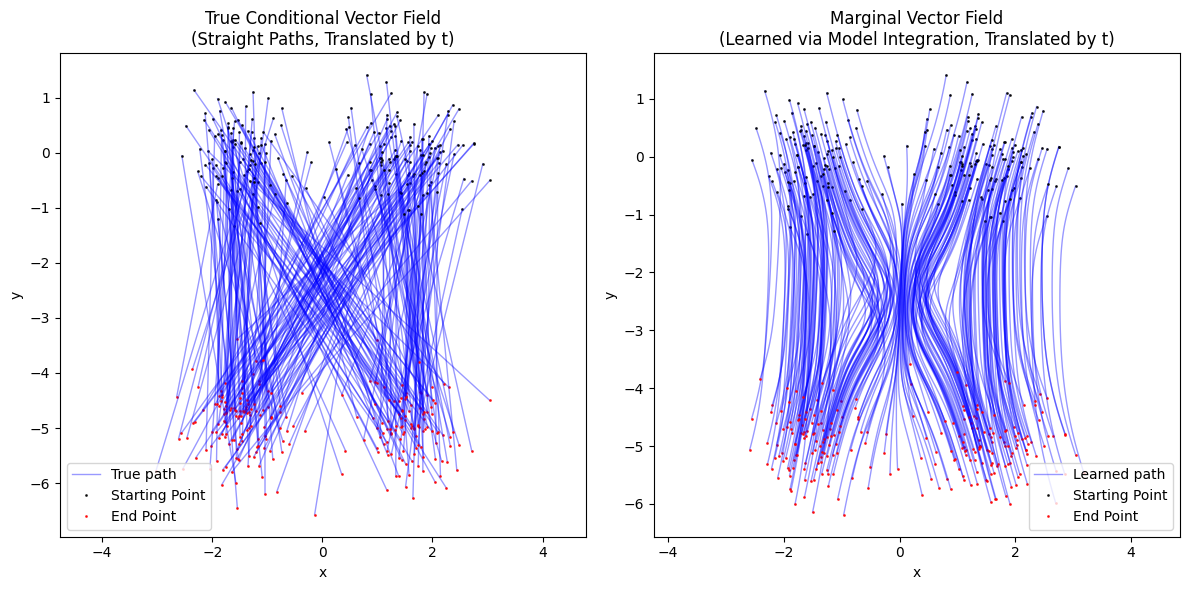

In [7]:
import torch
import matplotlib.pyplot as plt

def visualize_vector_fields(model, dataset_obj, use_conditioning=False, mini_batch_ot=False, n_paths=10, n_steps=100):
    """
    Visualize the true conditional vector field (with straight paths) and the 
    marginal vector field learned by the model (via integration) for a subset of x0.
    
    Each marginal p_t is translated by its time value t on the x-axis, i.e.:
    for each point, the x coordinate is increased by t.
    
    Parameters:
        model (torch.nn.Module): Trained model predicting the vector field.
        x0 (torch.Tensor): Tensor of initial datapoints, shape [N, dim].
        x1 (torch.Tensor): Tensor of corresponding target points (noise), shape [N, dim].
        n_paths (int): Number of paths to visualize.
        n_steps (int): Number of integration steps for the model's path.
    """
    X, Labels = dataset_obj[:n_paths]
    x0 = X[:, 0, :].to(device)
    x1 = X[:, 1, :].to(device) # or any other corresponding target points
    if mini_batch_ot:
        # Compute the pairwise cost matrix between x0 and x1 using squared Euclidean distance.
        cost_matrix = torch.cdist(x0, x1, p=2) ** 2
        cost_matrix_np = cost_matrix.detach().cpu().numpy()
        # Compute the optimal assignment (Hungarian algorithm)
        row_ind, col_ind = linear_sum_assignment(cost_matrix_np)
        # Permute x1 according to the optimal transport plan
        x1 = x1[col_ind]
        
    if use_conditioning:
        y = torch.randint(0, 2, (n_paths,), device=device)
    else:
        y = None

    # --- Compute True Conditional Paths ---
    # Create time steps: shape [n_steps, 1, 1]
    t_values = torch.linspace(0, 1, steps=n_steps, device=device).view(n_steps, 1, 1)
    # Compute the straight-line interpolation in parallel:
    paths_true = (1 - t_values) * x0.unsqueeze(0) + t_values * x1.unsqueeze(0)
    # paths_true shape: [n_steps, n_paths, dim]
    # Translate each marginal p_t by t on the x-axis (only update the first coordinate)
    paths_true_translated = paths_true.clone()
    paths_true_translated[:, :, 1] -= 5*t_values.squeeze(-1)  # t_values now shape: [n_steps, 1]

    # --- Compute Learned (Marginal) Paths via Euler Integration ---
    dt = 1.0 / n_steps
    # Start integration from x0_vis (all in one batch)
    x = x0.clone()  # shape: [n_paths, dim]
    learned_paths = [x.clone()]
    
    # Iterate over time steps in parallel for all paths:
    for step in range(n_steps):
        # Create a time tensor for the current integration step: shape [n_paths, 1]
        t = torch.full((n_paths, 1), step * dt, device=device)
        with torch.no_grad():
            v = model(x, t, y)  # model is applied to the entire batch
        x = x + dt * v
        learned_paths.append(x.clone())
    # Stack learned paths: shape [n_steps+1, n_paths, dim]
    paths_learned = torch.stack(learned_paths, dim=0)
    # Create time steps for learned paths (n_steps+1), shape: [n_steps+1, 1]
    t_values_learned = torch.linspace(0, 1, steps=n_steps+1, device=device).view(n_steps+1, 1)
    # Translate each marginal by t on the x-axis:
    paths_learned_translated = paths_learned.clone()
    paths_learned_translated[:, :, 1] -= 5*t_values_learned  # broadcasting t over paths

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    
    # Plot True Conditional Vector Field (translated straight paths)
    plt.subplot(1, 2, 1)
    for i in range(n_paths):
        path = paths_true_translated[:, i, :]  # shape: [n_steps, dim]
        plt.plot(path[:, 0].cpu().numpy(), path[:, 1].cpu().numpy(),
                
                label='True path' if i == 0 else None, alpha=0.4, linewidth=1,
                 color= 'orange' if (y is not None) and (y[i] == 0) else 'blue')
        # Mark starting point
        plt.plot(path[0, 0].cpu().numpy(), path[0, 1].cpu().numpy(),
                 'ko', label='Starting Point' if i == 0 else None, markersize=1, alpha=0.8)
        # Mark end point
        plt.plot(path[-1, 0].cpu().numpy(), path[-1, 1].cpu().numpy(),
                 'ro', label='End Point' if i == 0 else None, markersize=1, alpha=0.8)
    plt.title('True Conditional Vector Field\n(Straight Paths, Translated by t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
    
    # Plot Learned Marginal Vector Field (translated via model integration)
    plt.subplot(1, 2, 2)
    for i in range(n_paths):
        path = paths_learned_translated[:, i, :]  # shape: [n_steps+1, dim]
        plt.plot(path[:, 0].cpu().numpy(), path[:, 1].cpu().numpy(),
                 label='Learned path' if i == 0 else None, alpha=0.4, linewidth=1,
                 color= 'orange' if (y is not None) and (y[i] == 0) else 'blue')
        # Mark starting point
        plt.plot(path[0, 0].cpu().numpy(), path[0, 1].cpu().numpy(),
                 'ko', label='Starting Point' if i == 0 else None, markersize=1, alpha=0.8)
        # Mark end point
        plt.plot(path[-1, 0].cpu().numpy(), path[-1, 1].cpu().numpy(),
                 'ro', label='End Point' if i == 0 else None, markersize=1, alpha=0.8)
    plt.title('Marginal Vector Field\n(Learned via Model Integration, Translated by t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()

visualize_vector_fields(simple_model, dataset_obj=dataset_obj, use_conditioning=False, mini_batch_ot=False, n_paths=250, n_steps=100)

## Case Study 2: Straighten the paths with a better coupling: mini-batch ot

In [8]:
# RUN!
simple_model_ot, optimizer_ot = get_model_and_optimizer(num_classes=0)
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=dataloader,
    model=simple_model_ot,
    optimizer=optimizer_ot,
    checkpoint_dir='checkpoints_ot',
    device=device,
    use_conditioning=False,
    mini_batch_ot=True
)

Training on device: mps
Epoch [1] Average Loss: 0.0911
Epoch [2] Average Loss: 0.0385
Epoch [3] Average Loss: 0.0375
Epoch [4] Average Loss: 0.0377
Epoch [5] Average Loss: 0.0375
Epoch [6] Average Loss: 0.0375
Epoch [7] Average Loss: 0.0375
Epoch [8] Average Loss: 0.0377
Epoch [9] Average Loss: 0.0379
Epoch [10] Average Loss: 0.0382
Epoch [11] Average Loss: 0.0387
Epoch [12] Average Loss: 0.0394
Epoch [13] Average Loss: 0.0400
Epoch [14] Average Loss: 0.0405
Epoch [15] Average Loss: 0.0405
Epoch [16] Average Loss: 0.0400
Epoch [17] Average Loss: 0.0393
Epoch [18] Average Loss: 0.0387
Epoch [19] Average Loss: 0.0382
Epoch [20] Average Loss: 0.0380
Epoch [21] Average Loss: 0.0379
Epoch [22] Average Loss: 0.0377
Epoch [23] Average Loss: 0.0375
Epoch [24] Average Loss: 0.0373
Epoch [25] Average Loss: 0.0372
Epoch [26] Average Loss: 0.0370
Epoch [27] Average Loss: 0.0369
Epoch [28] Average Loss: 0.0368
Epoch [29] Average Loss: 0.0368
Epoch [30] Average Loss: 0.0367
Epoch [31] Average Loss: 

100%|██████████| 100/100 [00:00<00:00, 670.38it/s]


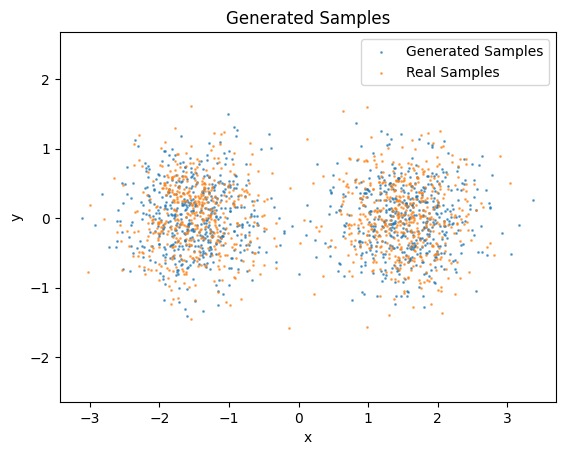

In [9]:
samples = sample(
    model=simple_model_ot,
    n_samples=1000,
    n_steps=100,
    use_conditioning=False,
)

# plot samples
tmp_samples = samples.clip(-5, 5)
plt.scatter(tmp_samples[:, 0], tmp_samples[:, 1], s=1, alpha=0.6, label = 'Generated Samples')
plt.scatter(gaussian_datapoints[:samples.shape[0], 1, 0], gaussian_datapoints[:samples.shape[0], 1, 1], s=1, alpha=0.6, label='Real Samples')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.legend()
plt.title('Generated Samples')
plt.show()

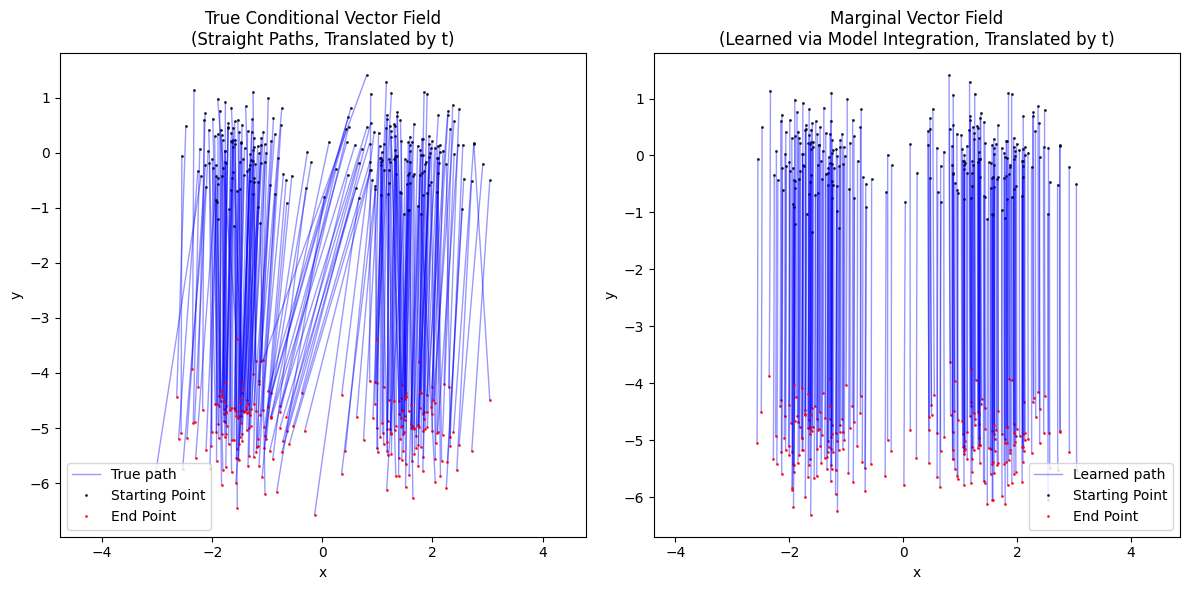

In [10]:
visualize_vector_fields(simple_model_ot, dataset_obj=dataset_obj, use_conditioning=False, mini_batch_ot=True, n_paths=250, n_steps=100)

## Case Study 3: Compare mini-batch ot coupling with simple conditioning 

In [11]:
simple_model_conditioned, optimizer_condtioned = get_model_and_optimizer(num_classes=2)
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=dataloader,
    model=simple_model_conditioned,
    optimizer=optimizer_condtioned,
    checkpoint_dir='checkpoints_conditioned',
    device=device,
    use_conditioning=True,
    mini_batch_ot=False
)

Training on device: mps
Epoch [1] Average Loss: 2.4004
Epoch [2] Average Loss: 1.0787
Epoch [3] Average Loss: 0.9757
Epoch [4] Average Loss: 0.9468
Epoch [5] Average Loss: 0.9079
Epoch [6] Average Loss: 0.8691
Epoch [7] Average Loss: 0.8466
Epoch [8] Average Loss: 0.8543
Epoch [9] Average Loss: 0.8264
Epoch [10] Average Loss: 0.8363
Epoch [11] Average Loss: 0.8216
Epoch [12] Average Loss: 0.8021
Epoch [13] Average Loss: 0.8101
Epoch [14] Average Loss: 0.7996
Epoch [15] Average Loss: 0.7821
Epoch [16] Average Loss: 0.7995
Epoch [17] Average Loss: 0.7661
Epoch [18] Average Loss: 0.7620
Epoch [19] Average Loss: 0.7728
Epoch [20] Average Loss: 0.7738
Epoch [21] Average Loss: 0.7802
Epoch [22] Average Loss: 0.7674
Epoch [23] Average Loss: 0.7486
Epoch [24] Average Loss: 0.7631
Epoch [25] Average Loss: 0.7561
Epoch [26] Average Loss: 0.7707
Epoch [27] Average Loss: 0.7750
Epoch [28] Average Loss: 0.7628
Epoch [29] Average Loss: 0.7694
Epoch [30] Average Loss: 0.7663
Epoch [31] Average Loss: 

100%|██████████| 100/100 [00:00<00:00, 528.77it/s]


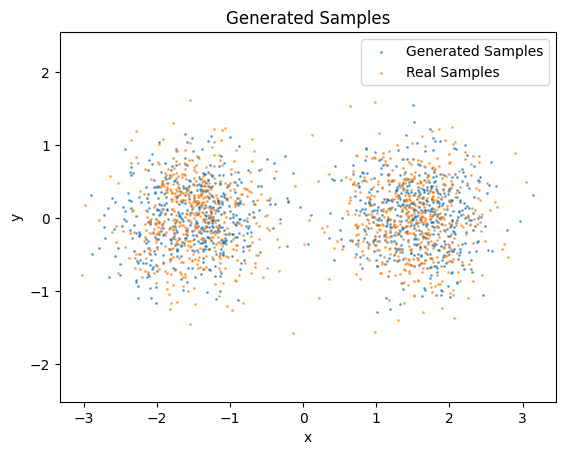

In [12]:
samples = sample(
    model=simple_model_conditioned,
    n_samples=1000,
    n_steps=100,
    use_conditioning=True
)

# plot samples
tmp_samples = samples.clip(-5, 5)
plt.scatter(tmp_samples[:, 0], tmp_samples[:, 1], s=1, alpha=0.6, label = 'Generated Samples')
plt.scatter(gaussian_datapoints[:samples.shape[0], 1, 0], gaussian_datapoints[:samples.shape[0], 1, 1], s=1, alpha=0.6, label='Real Samples')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.legend()
plt.title('Generated Samples')
plt.show()

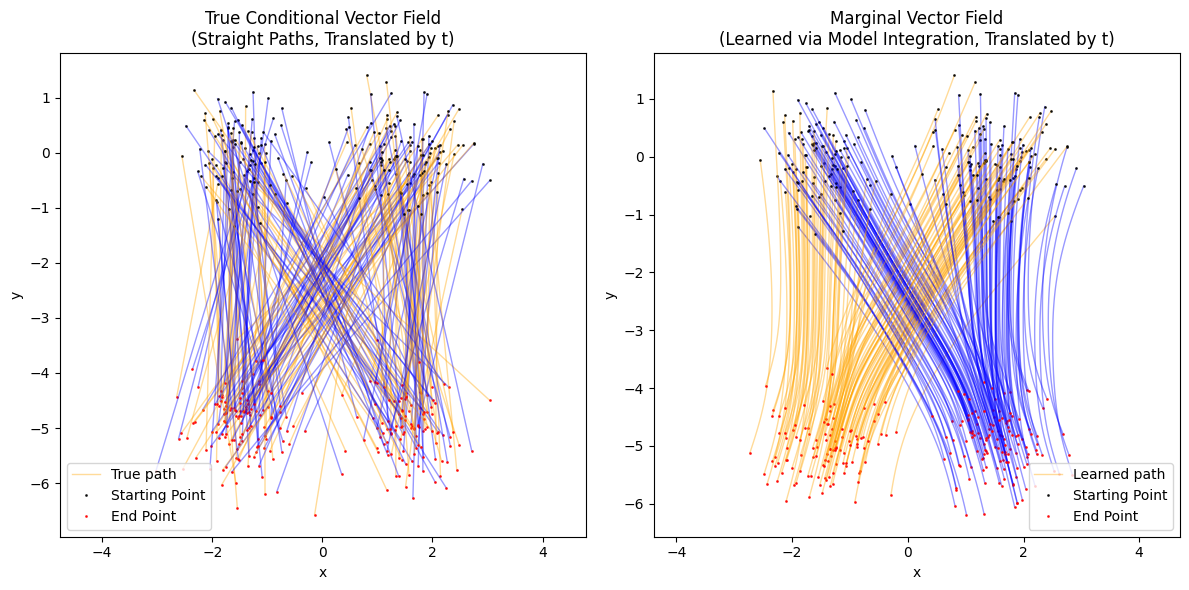

In [13]:
visualize_vector_fields(simple_model_conditioned, dataset_obj=dataset_obj, use_conditioning=True, mini_batch_ot=False, n_paths=250, n_steps=100)

## Case Study 4: Straigther paths with reflow

In [14]:
simple_model_reflow, optimizer_reflow = get_model_and_optimizer(num_classes=0)

# first step of reflow; train the model with default independent coupling
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=dataloader,
    model=simple_model_reflow,
    optimizer=optimizer_reflow,
    checkpoint_dir='checkpoints_reflow',
    device=device,
    use_conditioning=False,
    mini_batch_ot=False
)

Training on device: mps
Epoch [1] Average Loss: 2.7620
Epoch [2] Average Loss: 2.6415
Epoch [3] Average Loss: 2.1666
Epoch [4] Average Loss: 1.8918
Epoch [5] Average Loss: 1.8099
Epoch [6] Average Loss: 1.7640
Epoch [7] Average Loss: 1.7541
Epoch [8] Average Loss: 1.7735
Epoch [9] Average Loss: 1.7170
Epoch [10] Average Loss: 1.7170
Epoch [11] Average Loss: 1.7116
Epoch [12] Average Loss: 1.6905
Epoch [13] Average Loss: 1.7156
Epoch [14] Average Loss: 1.7175
Epoch [15] Average Loss: 1.6692
Epoch [16] Average Loss: 1.7171
Epoch [17] Average Loss: 1.6733
Epoch [18] Average Loss: 1.7086
Epoch [19] Average Loss: 1.6711
Epoch [20] Average Loss: 1.7125
Epoch [21] Average Loss: 1.7031
Epoch [22] Average Loss: 1.6800
Epoch [23] Average Loss: 1.6740
Epoch [24] Average Loss: 1.6692
Epoch [25] Average Loss: 1.6960
Epoch [26] Average Loss: 1.6792
Epoch [27] Average Loss: 1.6703
Epoch [28] Average Loss: 1.6563
Epoch [29] Average Loss: 1.6556
Epoch [30] Average Loss: 1.6803
Epoch [31] Average Loss: 

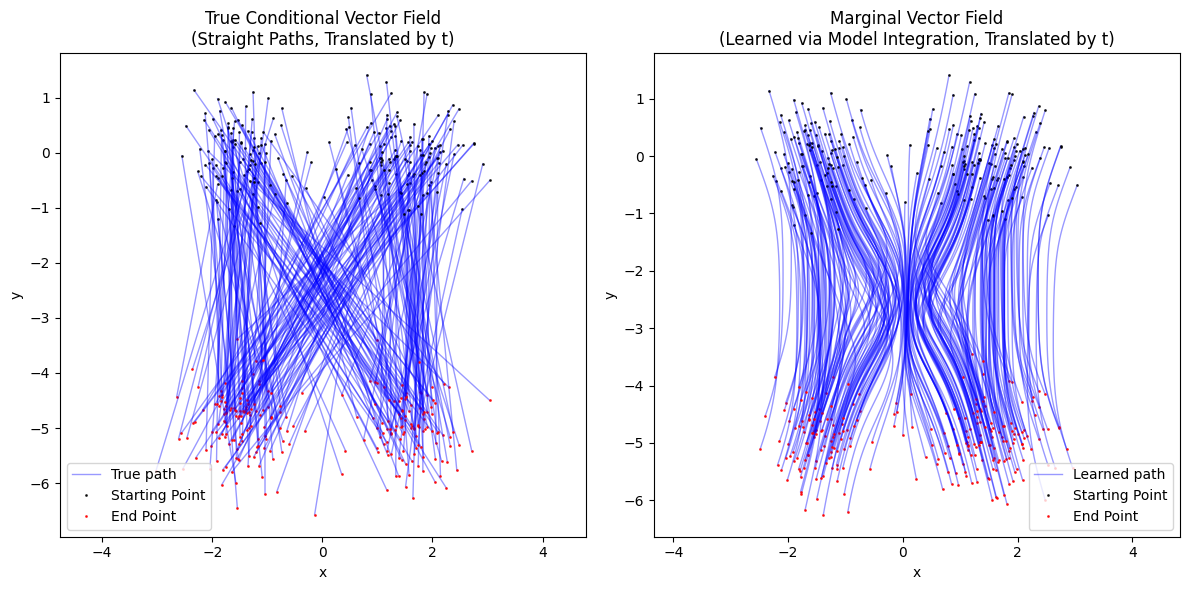

In [15]:
visualize_vector_fields(simple_model_reflow, dataset_obj=dataset_obj, use_conditioning=False, mini_batch_ot=False, n_paths=250, n_steps=100)

In [16]:
# Then, we sample from the model trained with independent coupling and use the samples as the new dataset.

gaussian_datapoints_1_reflow = []
total_data = gaussian_datapoints_0.shape[0]
batch_size = 2000
for i in range(0, len(gaussian_datapoints_0), batch_size):
    tmp = sample(
        model=simple_model_reflow,
        n_samples=min(batch_size, total_data - i),
        n_steps=200,
        use_conditioning=False
    )
    gaussian_datapoints_1_reflow.append(tmp)
gaussian_datapoints_1_reflow = torch.cat(gaussian_datapoints_1_reflow, dim=0).unsqueeze(1)

gaussian_datapoints_reflow = torch.cat([gaussian_datapoints_0, gaussian_datapoints_1_reflow], dim=1)
print('gaussian_datapoints_reflow shape', gaussian_datapoints_reflow.shape)
labels_1_reflow = torch.zeros_like(labels_0)
labels_reflow = torch.cat([labels_0, labels_1_reflow], dim=1)
print('labels_reflow shape', labels_reflow.shape)

reflow_dataset_obj = create_dataset(gaussian_datapoints_reflow, labels_reflow)
reflow_dataloader = create_dataloader(reflow_dataset_obj, batch_size=500)

100%|██████████| 200/200 [00:00<00:00, 640.65it/s]

gaussian_datapoints_reflow shape torch.Size([10000, 2, 2])
labels_reflow shape torch.Size([10000, 2])


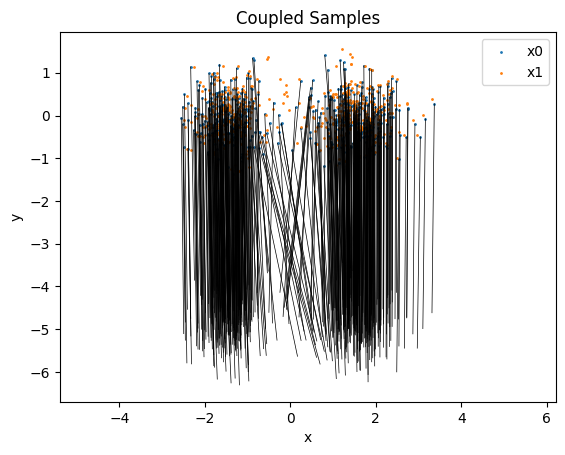

In [17]:
# plot coupled 

# plot coupled samples from the dataloader. Verify they are coupled.
for i, (data, y) in enumerate(reflow_dataloader):
    x0 = data[:, 0, :]
    x1 = data[:, 1, :]
    plt.scatter(x0[:, 0], x0[:, 1], s=1, label='x0')
    plt.scatter(x1[:, 0], x1[:, 1], s=1, label='x1')
    # now trace the line joining the points
    for j in range(len(x0)):
        plt.plot([x0[j, 0], x1[j, 0]], [x0[j, 1], x1[j, 1] - 5], 'k-', lw=0.5)
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Coupled Samples')
    plt.show()
    
    
    
    break 

In [18]:
# second step of reflow; train the model with the new coupling
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=reflow_dataloader,
    model=simple_model_reflow,
    optimizer=optimizer_reflow,
    checkpoint_dir='checkpoints_reflow_1',
    device=device,
    use_conditioning=False,
    mini_batch_ot=False
)

Training on device: mps
Epoch [1] Average Loss: 1.6488
Epoch [2] Average Loss: 1.6124
Epoch [3] Average Loss: 1.5260
Epoch [4] Average Loss: 1.4969
Epoch [5] Average Loss: 1.5190
Epoch [6] Average Loss: 1.4933
Epoch [7] Average Loss: 1.5026
Epoch [8] Average Loss: 1.4961
Epoch [9] Average Loss: 1.4618
Epoch [10] Average Loss: 1.5213
Epoch [11] Average Loss: 1.4766
Epoch [12] Average Loss: 1.4847
Epoch [13] Average Loss: 1.5289
Epoch [14] Average Loss: 1.5049
Epoch [15] Average Loss: 1.5213
Epoch [16] Average Loss: 1.4625
Epoch [17] Average Loss: 1.5331
Epoch [18] Average Loss: 1.4811
Epoch [19] Average Loss: 1.4616
Epoch [20] Average Loss: 1.4688
Epoch [21] Average Loss: 1.4738
Epoch [22] Average Loss: 1.4629
Epoch [23] Average Loss: 1.5132
Epoch [24] Average Loss: 1.4386
Epoch [25] Average Loss: 1.4724
Epoch [26] Average Loss: 1.4734
Epoch [27] Average Loss: 1.4620
Epoch [28] Average Loss: 1.4825
Epoch [29] Average Loss: 1.4659
Epoch [30] Average Loss: 1.5039
Epoch [31] Average Loss: 

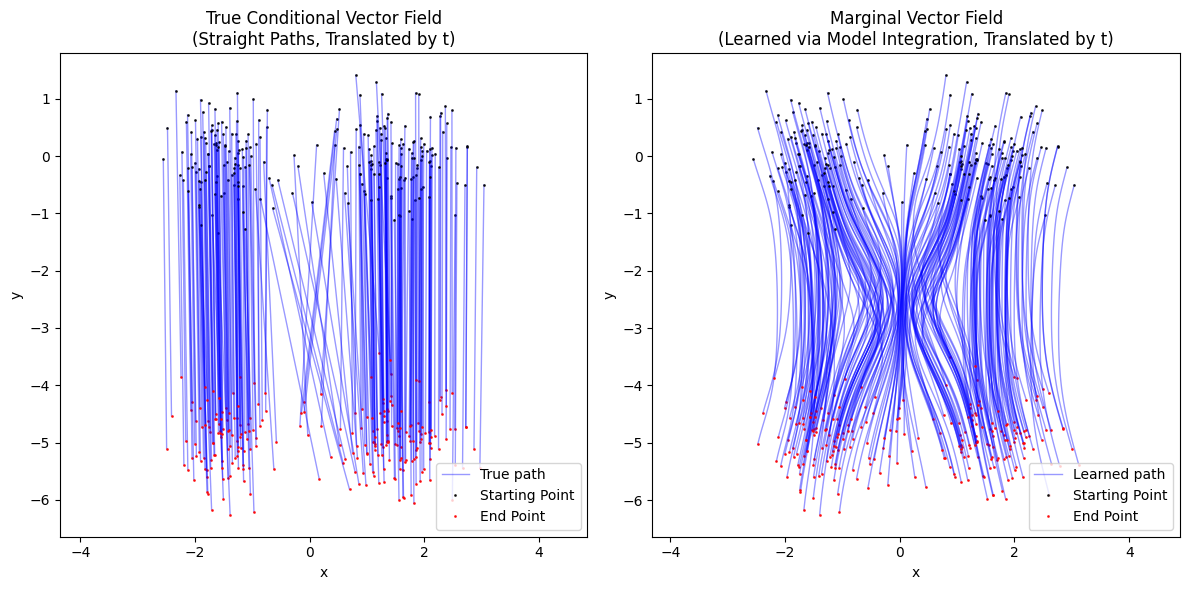

In [19]:
visualize_vector_fields(simple_model_reflow, dataset_obj=reflow_dataset_obj, use_conditioning=False, mini_batch_ot=False, n_paths=250, n_steps=100)

# Bride Matching

Device in use: mps
Using Gaussian Mixture dataset, with parameters mean=[-1.5, 0.0], [1.5, 0.0] and std=0.5. 10000 samples.


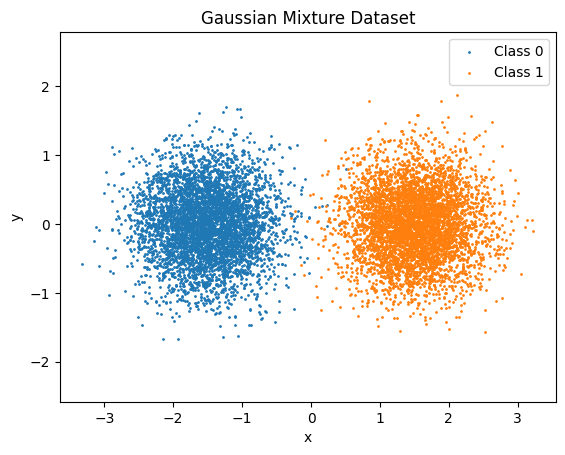

Using Gaussian Mixture dataset, with parameters mean=[-1.5, 0.0], [1.5, 0.0] and std=0.5. 10000 samples.
Using Gaussian Mixture dataset, with parameters mean=[-1.5, 0.0], [1.5, 0.0] and std=0.5. 10000 samples.
dataset shape torch.Size([10000, 2, 2])
labels shape torch.Size([10000, 2])


In [20]:
import torch

def get_device():
    """
    Returns the available device ('cuda', 'mps', or 'cpu').
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
    
device = get_device()
print('Device in use:', device)

# Create a dataset with a Gaussian mixture distribution:
def get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples):
    print('Using Gaussian Mixture dataset, with parameters mean=[{}, {}], [{}, {}] and std={}. {} samples.'
          .format(mean1[0], mean1[1], mean2[0], mean2[1], std, n_samples))
    # Half the samples from each mixture component.
    samples1 = torch.randn(n_samples // 2, 2) * std + mean1
    samples2 = torch.randn(n_samples - n_samples // 2, 2) * std + mean2
    samples = torch.concatenate([samples1, samples2], dim=0)
    labels = torch.zeros(n_samples)
    labels[n_samples // 2:] = 1
    return samples, labels

def get_default_gaussian_mixture_datapoints():
    mean1 = torch.tensor([-1.5, 0])
    mean2 = torch.tensor([1.5, 0])
    std = 0.5
    n_samples = 10000
    gaussian_datapoints, labels = get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples)
    # shuffle the data
    perm = torch.randperm(n_samples)
    gaussian_datapoints = gaussian_datapoints[perm]
    labels = labels[perm]
    return gaussian_datapoints, labels

# random shuffle
gaussian_datapoints, labels = get_default_gaussian_mixture_datapoints()

# plot the Gaussian mixture dataset
import matplotlib.pyplot as plt
plt.scatter(gaussian_datapoints[labels == 0, 0], gaussian_datapoints[labels == 0, 1], s=1, label='Class 0')
plt.scatter(gaussian_datapoints[labels == 1, 0], gaussian_datapoints[labels == 1, 1], s=1, label='Class 1')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Gaussian Mixture Dataset')
plt.show()


# Create a TensorDataset
def create_dataset(datapoints, labels):
    dataset_obj = torch.utils.data.TensorDataset(datapoints, labels)
    return dataset_obj

def create_dataloader(dataset, batch_size):
    # Create a DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False
        )
    return dataloader


gaussian_datapoints_0, labels_0 = get_default_gaussian_mixture_datapoints()
gaussian_datapoints_1, labels_1 = get_default_gaussian_mixture_datapoints()
gaussian_datapoints_0 = gaussian_datapoints_0.unsqueeze_(1)
gaussian_datapoints_1 = gaussian_datapoints_1.unsqueeze_(1)
labels_0 = labels_0.unsqueeze_(1)
labels_1 = labels_1.unsqueeze_(1)
gaussian_datapoints = torch.cat([gaussian_datapoints_0, gaussian_datapoints_1], dim=1)
labels = torch.cat([labels_0, labels_1], dim=1)
print('dataset shape', gaussian_datapoints.shape)
print('labels shape', labels.shape)
dataset_obj = create_dataset(gaussian_datapoints, labels)
dataloader = create_dataloader(dataset_obj, batch_size=500)

## Forward : sample $p_{t | 1}$

We implement the simplest bridge: 

$$d X_t = \frac{X_1 - X_t}{1 - t} dt + \sigma d B_t.$$

Then, 
$$X_t \sim tX_1 + (1-t)X_0 + \sigma \sqrt{t(1-t)} Z,$$ 
with $Z \sim \mathcal{0, I_d}$.





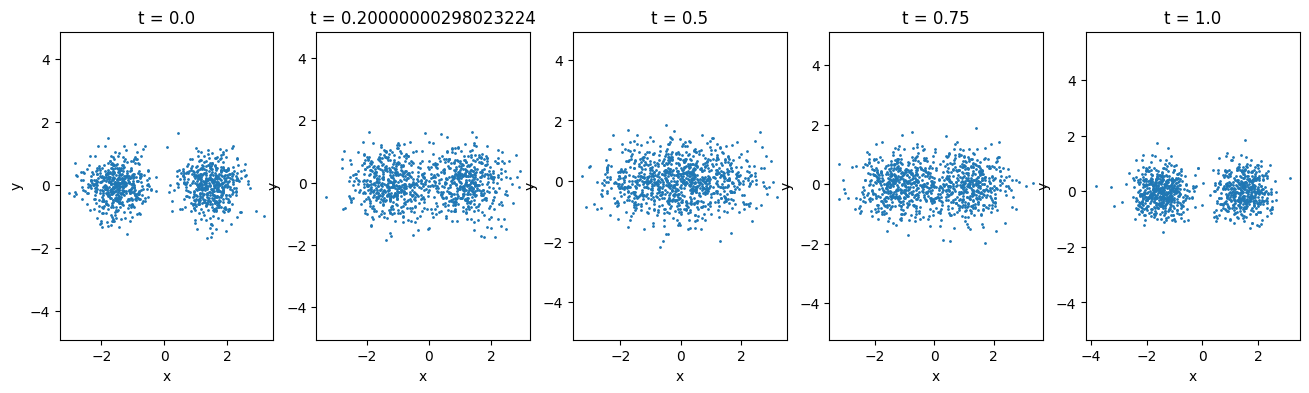

In [21]:
import torch

sigma = 1.

def simulation_free_forward(x0, x1, sigma, t):
    z = torch.randn_like(x0)
    return (1 - t) * x0 + t * x1 + sigma * torch.sqrt(t * (1 - t)) * z


# check the forward process by plotting the empirical marginals p_t, for some t and empirical samples

X, L = dataset_obj[:1000]
x1 = X[:, 1, :]
x0 = X[:, 0, :]

# create four subplots 
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

# plot the empirical marginals p_t
def plot_ax_i(ax, x, y, title):
    ax.scatter(x, y, s=1)
    ax.axis('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)

for i, t_norm in enumerate([0.0, 0.2, 0.5, 0.75, 1.0]):
    t = t_norm * torch.ones_like(x0)
    x_t = simulation_free_forward(x0, x1, sigma, t)
    plot_ax_i(axs[i], x_t[:, 0], x_t[:, 1], 't = {}'.format(t[0, 0]))

plt.show()




## Conditional Bridge Matching loss


**V-prediction**
The bridge matching loss is given by 

$$ \mathcal{L}_{\text{BFM}}(\theta) = \mathbb{E}\left[ \| v_{\theta}(X_t, t) - \frac{X_1 - X_t}{1 - t} \|^2 \right],$$ 
But
$$X_t \sim tX_1 + (1-t)X_0 + \sigma \sqrt{t(1-t)} Z,$$ 
with $Z \sim \mathcal{0, I_d}$, so

$$ \mathcal{L}_{\text{BFM}}(\theta) = \mathbb{E}\left[ \| v_{\theta}(X_t, t) - \left(X_1 - X_0 - \sigma \sqrt{\frac{t}{1 - t}} Z\right) \|^2 \right],$$ 

**X_1-prediction**
We parameterize $v_{\theta}$ as 
$$v_{\theta}(X_t, t) = \frac{X_1^{\theta}(X_t, t) - X_t}{1 - t} $$
The bridge matching loss is given by 
$$ \mathcal{L}_{\text{BFM}}(\theta) = \mathbb{E}\left[ \| X_1^{\theta}(X_t) - X_1 \|^2 \right],$$ 

In [22]:
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment  # for the optimal transport assignment

def training_losses(model, x0, x1, sigma, y, pred_type = 'v'):
    batch_size = x0.shape[0]
    
    # Sample a random time t for each sample in the batch (values in [0, 1])
    t = torch.rand(batch_size, device=x0.device)
    z = torch.randn_like(x0)
    # expand t tensor to the same shape as x0 and x1
    expanded_t = t.view(-1, 1).expand_as(x0)
    
    noise_term = sigma * torch.sqrt(expanded_t * (1 - expanded_t)) * z
    # Compute the simulation-free forward process: linear interpolation between x0 and x1
    x_t = (1 - expanded_t)* x0 + expanded_t* x1 + noise_term
    
    if pred_type == 'v':
        target = x1 - x0 - noise_term
    elif pred_type == 'x1':
        target = x1
    else:
        raise ValueError('pred_type should be either v or x1')
    
    # Predict the vector field using the neural network model.
    # We assume the model takes x_t and t as separate inputs.
    pred = model(x_t, t, y)
    
    # Compute the mean squared error loss between the predicted and target vector fields.
    loss = F.mse_loss(pred, target)
    
    return loss

# training loop

import os

def train(
    num_epochs, 
    checkpoint_interval, 
    dataloader,
    model,
    optimizer,
    checkpoint_dir,
    device,
    sigma,
    pred_type = 'v', 
    use_conditioning=False,
    mini_batch_ot=False,
):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()
    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        running_loss = 0.0
        for batch_idx, (data, y) in (enumerate(dataloader)):
            data = data.to(device) 
            optimizer.zero_grad()

            # extract x_0, x_1 with independent coupling
            x1 = data[:, 1, :]
            x0 = data[:, 0, :]
            
            y1 = None
            if use_conditioning:
                y1 = y[:, 1].to(device)
                y0 = y[:, 0]
            
            # If mini_batch_ot is True, we will compute the optimal transport plan between x0 and x1
            # and permute x1 according to the optimal transport plan.
            if mini_batch_ot:
                # Compute the pairwise cost matrix between x0 and x1 using squared Euclidean distance.
                cost_matrix = torch.cdist(x0, x1, p=2) ** 2
                cost_matrix_np = cost_matrix.detach().cpu().numpy()
                # Compute the optimal assignment (Hungarian algorithm)
                row_ind, col_ind = linear_sum_assignment(cost_matrix_np)
                # Permute x1 according to the optimal transport plan
                x1 = x1[col_ind]
                
            
            # Compute the training loss.
            loss = training_losses(model, x0=x0, x1=x1, sigma=sigma,  y=y1, pred_type = pred_type)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # Save a checkpoint every checkpoint_interval epochs.
        if epoch % checkpoint_interval == 0:
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_losses': epoch_losses,
            }, checkpoint_path)
            print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")


simple_model_bm, optimizer_bm = get_model_and_optimizer(num_classes=0)
sigma_bm = 0.5

# RUN!
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=dataloader,
    model=simple_model_bm,
    optimizer=optimizer_bm,
    checkpoint_dir='checkpoints_bm',
    device=device,
    sigma = sigma_bm,
    use_conditioning=False,
    mini_batch_ot=False
)

Training on device: mps
Epoch [1] Average Loss: 2.7920
Epoch [2] Average Loss: 2.7385
Epoch [3] Average Loss: 2.5100
Epoch [4] Average Loss: 2.0369
Epoch [5] Average Loss: 1.9941
Epoch [6] Average Loss: 1.9584
Epoch [7] Average Loss: 1.9542
Epoch [8] Average Loss: 1.8965
Epoch [9] Average Loss: 1.9008
Epoch [10] Average Loss: 1.9444
Epoch [11] Average Loss: 1.8941
Epoch [12] Average Loss: 1.8871
Epoch [13] Average Loss: 1.8809
Epoch [14] Average Loss: 1.8439
Epoch [15] Average Loss: 1.8452
Epoch [16] Average Loss: 1.8458
Epoch [17] Average Loss: 1.8710
Epoch [18] Average Loss: 1.8788
Epoch [19] Average Loss: 1.8618
Epoch [20] Average Loss: 1.8793
Epoch [21] Average Loss: 1.8484
Epoch [22] Average Loss: 1.8510
Epoch [23] Average Loss: 1.8445
Epoch [24] Average Loss: 1.8392
Epoch [25] Average Loss: 1.8463
Epoch [26] Average Loss: 1.8538
Epoch [27] Average Loss: 1.8605
Epoch [28] Average Loss: 1.8102
Epoch [29] Average Loss: 1.8611
Epoch [30] Average Loss: 1.8643
Epoch [31] Average Loss: 

In [23]:
# load the model from checkpoint
def load_model_from_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_losses = checkpoint['epoch_losses']
    return model, optimizer, epoch, epoch_losses

# load the model from the last checkpoint
checkpoint_path = 'checkpoints/checkpoint_epoch_50.pth'
simple_model, optimizer, epoch, epoch_losses = load_model_from_checkpoint(checkpoint_path, simple_model, optimizer)

## Generative Process; simulate the SDE

The generative process is simply given by

$$ d X_t = v_{\theta}(X_t, t) dt + \sigma d B_t $$

100%|██████████| 200/200 [00:00<00:00, 246.60it/s]


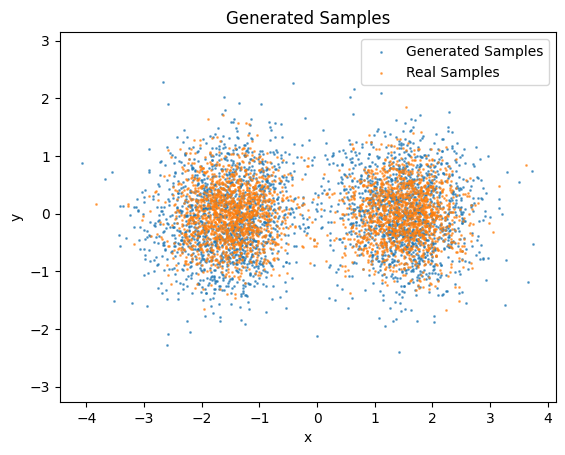

In [24]:
from tqdm import tqdm
import numpy as np

def sample(model, n_samples, n_steps, sigma, use_conditioning=False, pred_type = 'v'):
    
    # initial samples
    x0 = gaussian_datapoints[:n_samples, 0, :].to(device)
    if use_conditioning:
        y = labels[:n_samples, 1].to(device)
    else:
        y  = None
    
    model.eval()
    
    dt = 1.0 / n_steps
    x = x0.clone()  # Ensure we do not modify the original x0

    with torch.inference_mode():
        # Integrate from t=0 to t=1 in n_steps steps
        for i in tqdm(range(n_steps)):
            # Create a time tensor for the current step with shape (batch_size, 1)
            t = torch.full((x.shape[0], 1), i * dt, device=device)
            # Get the predicted vector field from the trained model
            pred = model(x, t, y)
            if pred_type == 'v':
                v = pred
            elif pred_type == 'x1':
                v = (pred - x)/ (1 - t)
            noise = sigma * torch.randn_like(x)
            # Update x using a simple Euler integration step
            x = x + dt * v + np.sqrt(dt)*noise
    return x.detach().cpu()



samples = sample(
    model=simple_model_bm,
    n_samples=3000,
    n_steps=200,
    sigma=sigma_bm,
    use_conditioning=False,
    pred_type='v'
)

# plot samples
tmp_samples = samples.clip(-5, 5)
plt.scatter(tmp_samples[:, 0], tmp_samples[:, 1], s=1, alpha=0.6, label = 'Generated Samples')
plt.scatter(gaussian_datapoints[:samples.shape[0], 1, 0], gaussian_datapoints[:samples.shape[0], 1, 1], s=1, alpha=0.6, label='Real Samples')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.legend()
plt.title('Generated Samples')
plt.show()

## Case Study 5: Visualize paths

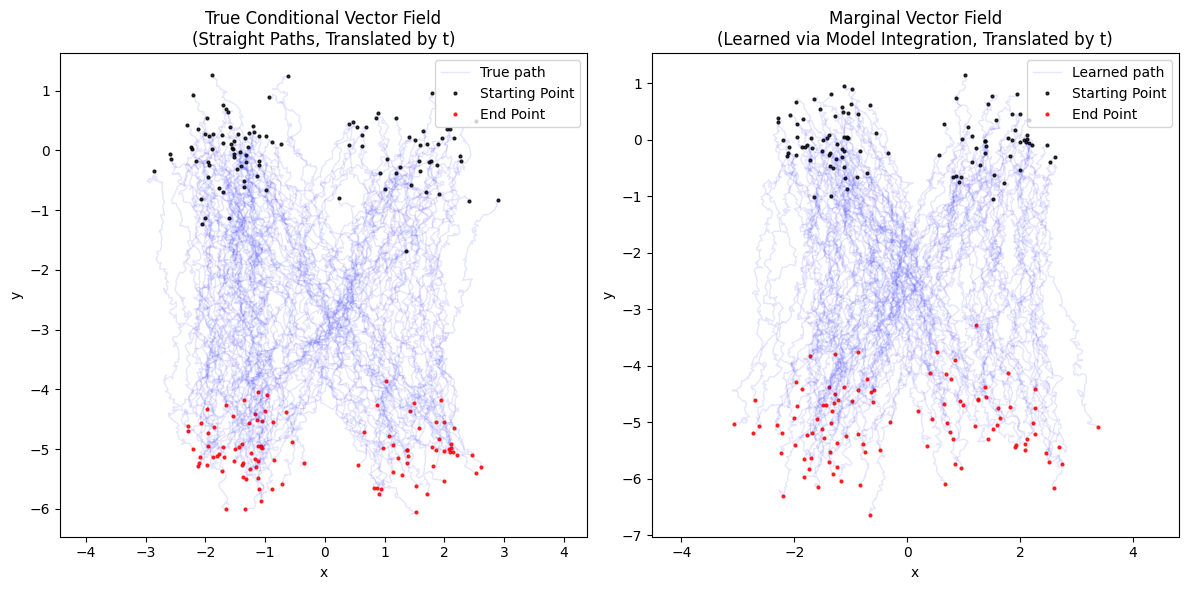

In [25]:
import torch
import matplotlib.pyplot as plt

def visualize_vector_fields(
    model, 
    dataset_obj, 
    sigma,
    use_conditioning=False, 
    mini_batch_ot=False, 
    n_paths=10, 
    n_steps=100, 
    pred_type = 'v'
    ):
    """
    Visualize the true conditional vector field (with straight paths) and the 
    marginal vector field learned by the model (via integration) for a subset of x0.
    
    Each marginal p_t is translated by its time value t on the x-axis, i.e.:
    for each point, the x coordinate is increased by t.
    
    Parameters:
        model (torch.nn.Module): Trained model predicting the vector field.
        x0 (torch.Tensor): Tensor of initial datapoints, shape [N, dim].
        x1 (torch.Tensor): Tensor of corresponding target points (noise), shape [N, dim].
        n_paths (int): Number of paths to visualize.
        n_steps (int): Number of integration steps for the model's path.
    """
    X, Labels = dataset_obj[:n_paths]
    x0 = X[:, 0, :].to(device)
    x1 = X[:, 1, :].to(device) # or any other corresponding target points
    if mini_batch_ot:
        # Compute the pairwise cost matrix between x0 and x1 using squared Euclidean distance.
        cost_matrix = torch.cdist(x0, x1, p=2) ** 2
        cost_matrix_np = cost_matrix.detach().cpu().numpy()
        # Compute the optimal assignment (Hungarian algorithm)
        row_ind, col_ind = linear_sum_assignment(cost_matrix_np)
        # Permute x1 according to the optimal transport plan
        x1 = x1[col_ind]
        
    if use_conditioning:
        y = torch.randint(0, 2, (n_paths,), device=device)
    else:
        y = None

    # --- Compute True Conditional Paths ---
    # Create time steps: shape [n_steps, 1, 1]
    t_values = torch.linspace(0, 1, steps=n_steps, device=device).view(n_steps, 1, 1)
    delta_t_values = t_values[1:] - t_values[:-1]
    # paths true is compute with dX_t = (X_1 - X_t)/(1 - t) dt + sigma dW_t 
    paths_true = torch.zeros(n_steps, n_paths, 2, device=device)
    paths_true[0] = x0.unsqueeze(0)
    for i in range(n_steps - 1):
        z = torch.randn_like(x0)
        v = (x1 - x0)/(1 - t_values[i])
        x0 = x0 + delta_t_values[i] * v + sigma * torch.sqrt(delta_t_values[i]) * z
        paths_true[i + 1] = x0
    # Translate each marginal p_t by t on the x-axis (only update the first coordinate)
    paths_true_translated = paths_true.clone()
    paths_true_translated[:, :, 1] -= 5*t_values.squeeze(-1)  # t_values now shape: [n_steps, 1]

    # --- Compute Learned (Marginal) Paths via Euler Integration ---
    dt = 1.0 / n_steps
    # Start integration from x0_vis (all in one batch)
    x = x0.clone()  # shape: [n_paths, dim]
    learned_paths = [x.clone()]
    
    # Iterate over time steps in parallel for all paths:
    for step in range(n_steps):
        # Create a time tensor for the current integration step: shape [n_paths, 1]
        t = torch.full((n_paths, 1), step * dt, device=device)
        with torch.no_grad():
            pred = model(x, t, y)  # model is applied to the entire batch_size
            if pred_type == 'v':
                v = pred
            elif pred_type == 'x1':
                v = (pred - x)/(1 - t)
            else:
                raise ValueError('pred_type should be either v or x1')
        z = torch.randn_like(x)
        noise_term = sigma * np.sqrt(dt) * z
        x = x + dt * v + noise_term
        learned_paths.append(x.clone())
    # Stack learned paths: shape [n_steps+1, n_paths, dim]
    paths_learned = torch.stack(learned_paths, dim=0)
    # Create time steps for learned paths (n_steps+1), shape: [n_steps+1, 1]
    t_values_learned = torch.linspace(0, 1, steps=n_steps+1, device=device).view(n_steps+1, 1)
    # Translate each marginal by t on the x-axis:
    paths_learned_translated = paths_learned.clone()
    paths_learned_translated[:, :, 1] -= 5*t_values_learned  # broadcasting t over paths

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    
    # Plot True Conditional Vector Field (translated straight paths)
    plt.subplot(1, 2, 1)
    for i in range(n_paths):
        path = paths_true_translated[:, i, :]  # shape: [n_steps, dim]
        plt.plot(path[:, 0].cpu().numpy(), path[:, 1].cpu().numpy(),
                
                label='True path' if i == 0 else None, alpha=0.1, linewidth=1,
                 color= 'orange' if (y is not None) and (y[i] == 0) else 'blue')
        # Mark starting point
        plt.plot(path[0, 0].cpu().numpy(), path[0, 1].cpu().numpy(),
                 'ko', label='Starting Point' if i == 0 else None, markersize=2, alpha=0.8)
        # Mark end point
        plt.plot(path[-1, 0].cpu().numpy(), path[-1, 1].cpu().numpy(),
                 'ro', label='End Point' if i == 0 else None, markersize=2, alpha=0.8)
    plt.title('True Conditional Vector Field\n(Straight Paths, Translated by t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
    
    # Plot Learned Marginal Vector Field (translated via model integration)
    plt.subplot(1, 2, 2)
    for i in range(n_paths):
        path = paths_learned_translated[:, i, :]  # shape: [n_steps+1, dim]
        plt.plot(path[:, 0].cpu().numpy(), path[:, 1].cpu().numpy(),
                 label='Learned path' if i == 0 else None, alpha=0.1, linewidth=1,
                 color= 'orange' if (y is not None) and (y[i] == 0) else 'blue')
        # Mark starting point
        plt.plot(path[0, 0].cpu().numpy(), path[0, 1].cpu().numpy(),
                 'ko', label='Starting Point' if i == 0 else None, markersize=2, alpha=0.8)
        # Mark end point
        plt.plot(path[-1, 0].cpu().numpy(), path[-1, 1].cpu().numpy(),
                 'ro', label='End Point' if i == 0 else None, markersize=2, alpha=0.8)
    plt.title('Marginal Vector Field\n(Learned via Model Integration, Translated by t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()

visualize_vector_fields(
    simple_model_bm, 
    dataset_obj=dataset_obj, 
    sigma=sigma_bm,
    use_conditioning=False, 
    mini_batch_ot=False, 
    n_paths=100, 
    n_steps=200, 
    pred_type='v'
)